In [83]:
import pandas as pd


data = pd.read_csv('../datasets/diamonds/diamonds.csv')

In [84]:
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82


### Dataset First look

I like tfdv. However it run only in amd architectures and my sistem is arm (Mac M1). So I run it on google colab and paste the output as images

In [85]:
%%writefile _

import tensorflow_data_validation as tfdv

stats = tfdv.generate_statistics_from_dataframe(data, tfdv.StatsOptions(label_feature='price'))
tfdv.visualize_statistics(stats)

Overwriting _


Output:
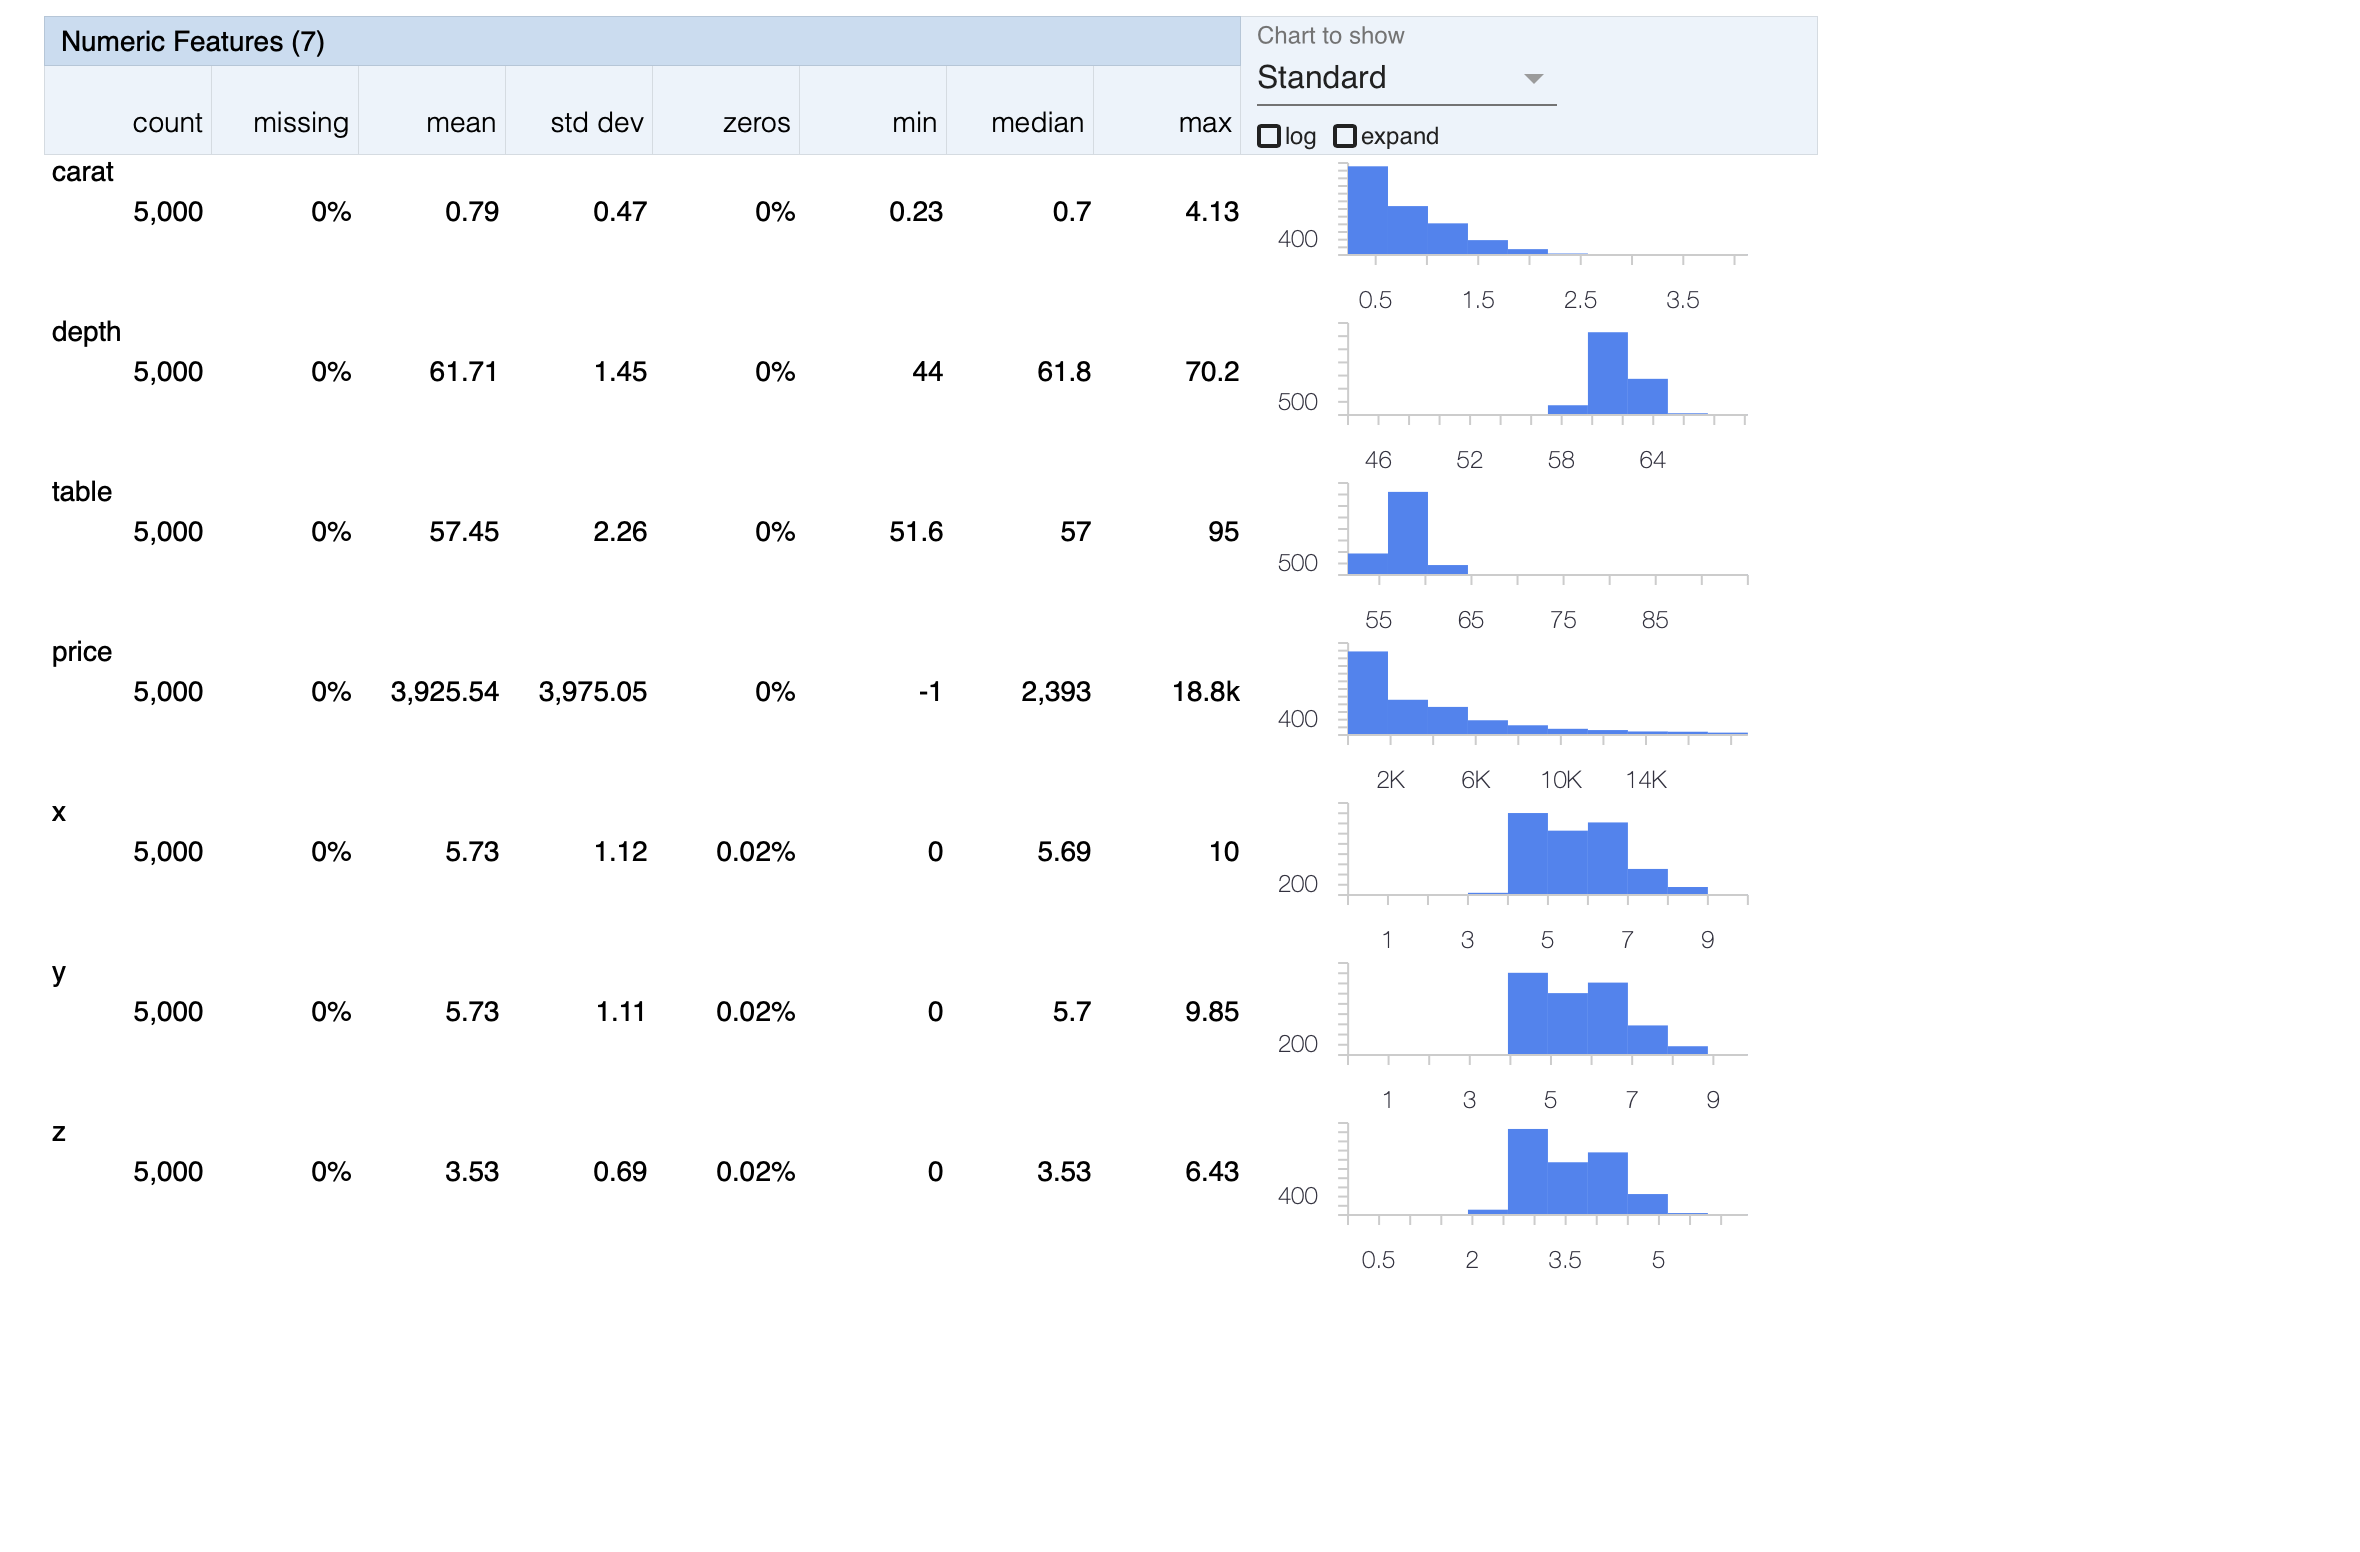
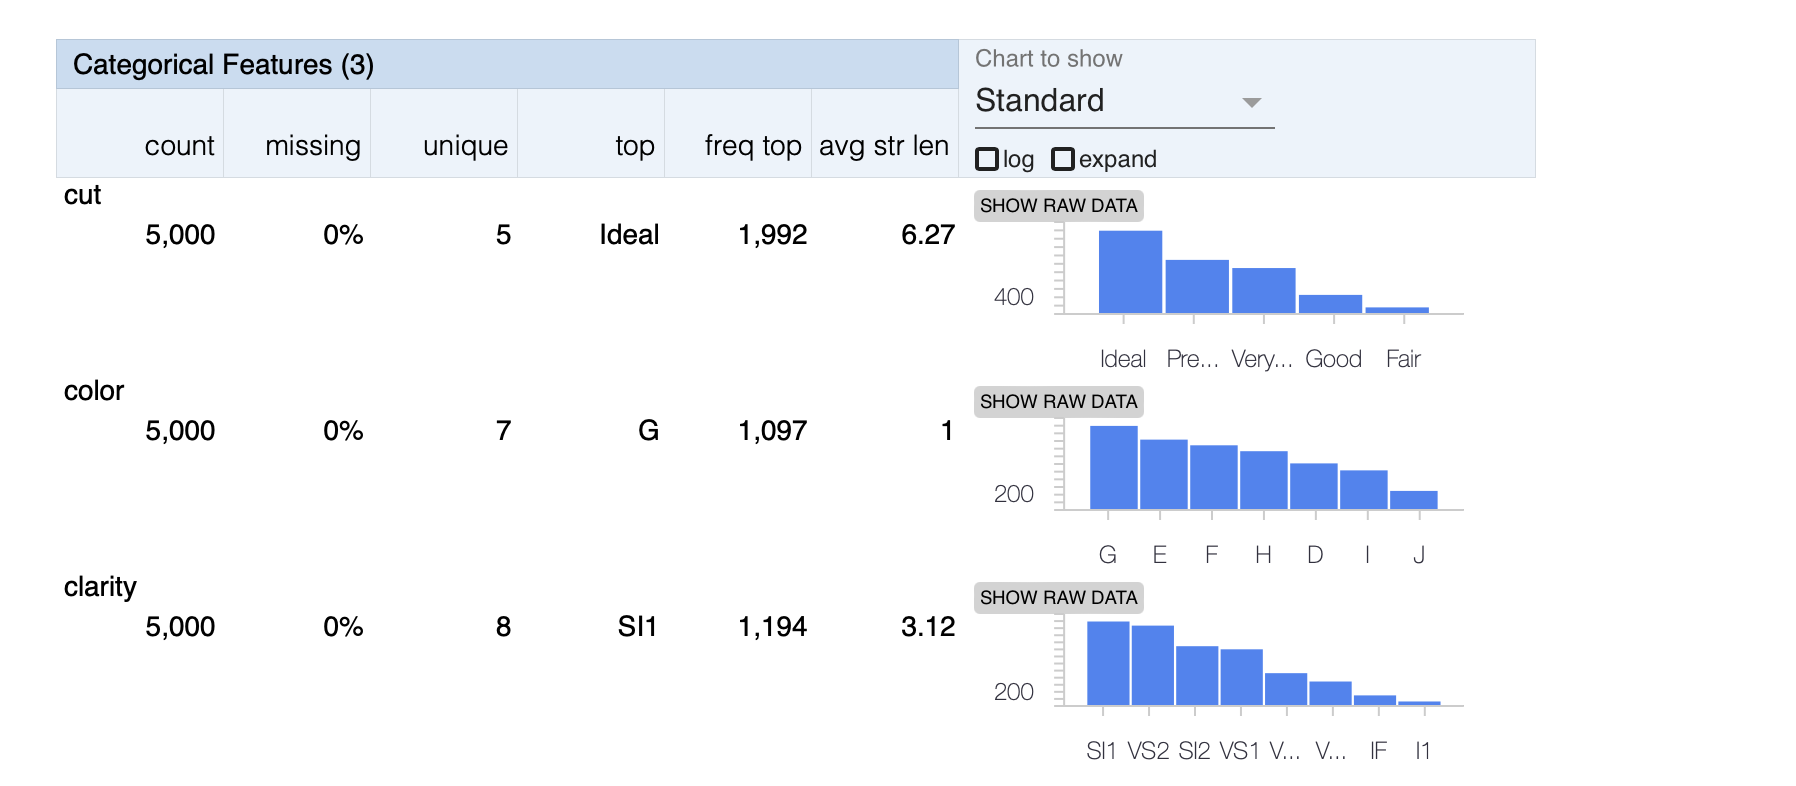

> The dataset seems complete, and the variables follow a standard distribution. However, there are several points to consider
>
> Review:
> - The dataset has negative prices (-1)
> - Some sizes on the x, y, z axes are 0
> - Check distributions with long tails (outliers)
> - Check categorical features
> 
> To Do:
> - Encode categorical features
> - Scale numerical variables

In [86]:
CATEGORICAL_FEATURES = ['cut', 'color', 'clarity']
NUMERICAL_FEATURES = ['carat', 'depth', 'table', 'x', 'y', 'z']
TARGET = 'price'
NUMERICAL_DATA = NUMERICAL_FEATURES + [TARGET]

### Preprocess

REVIEW: price = -1

In [87]:
data.loc[data['price'] <= 10]

,carat,cut,color,clarity,depth,table,price,x,y,z
331,1.00,Good,F,SI1,64.1,60.0,-1,6.25,6.19,3.99
2121,0.34,Ideal,E,VS2,59.8,56.0,-1,4.55,4.54,2.72
2484,1.75,Ideal,J,SI1,63.3,59.0,-1,7.63,7.57,4.81
2933,1.51,Ideal,H,VS2,62.5,55.0,-1,7.29,7.34,4.57
3155,0.31,Ideal,G,VS2,61.7,57.0,-1,4.33,4.36,2.68
3317,1.02,Premium,D,VS2,59.8,61.0,-1,6.61,6.54,3.93
3445,0.30,Premium,H,SI1,59.3,59.0,-1,4.38,4.36,2.59
3904,0.90,Very Good,G,SI2,64.2,56.0,-1,6.04,6.11,3.90
3980,0.41,Very Good,H,VS2,63.4,58.0,-1,4.77,4.66,2.99
4188,0.79,Ideal,H,VVS1,62.0,56.0,-1,5.92,5.96,3.68


In [88]:
data.loc[data['price'] > 10].head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82


> Comparing these two tables, we see that the price behavior is illogical since the diamonds seem good. So, I will delete the data.

In [89]:
data = data.loc[data['price'] > 0]

REVIEW: sizes = 0

In [90]:
data.loc[data['x'] < 3]

,carat,cut,color,clarity,depth,table,price,x,y,z
4321,2.25,Premium,H,SI2,62.8,59.0,18034,0.0,0.0,0.0


> We can see that the price is expensive and the diamond doesn't exists. So I will drop it

In [91]:
data = data.loc[data['x'] > 0]
data = data.loc[data['y'] > 0]
data = data.loc[data['z'] > 0]

REVIEW: Checking outliers



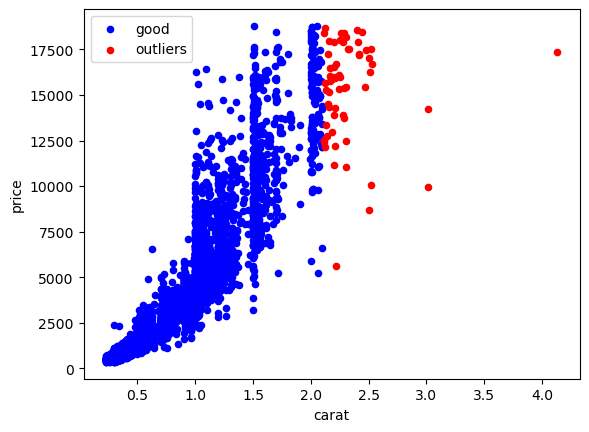

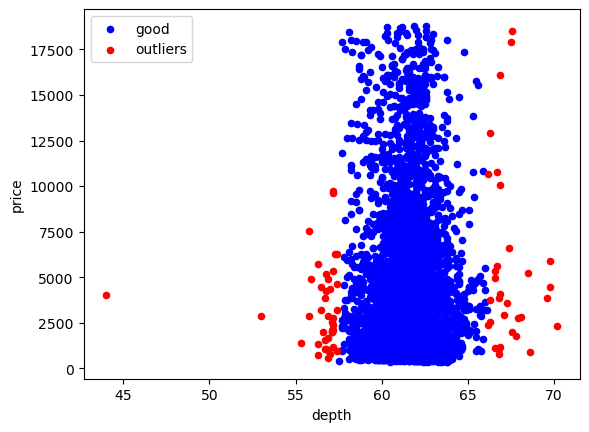

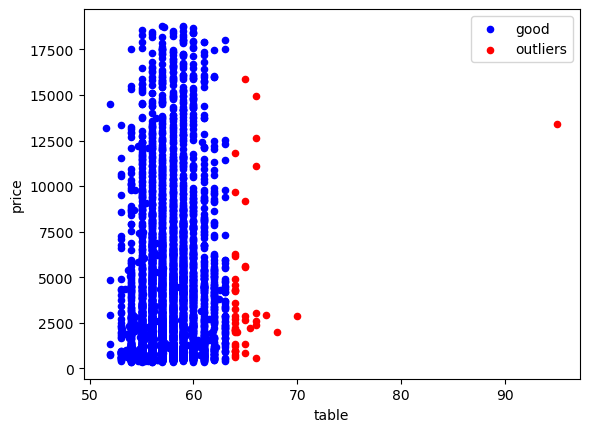

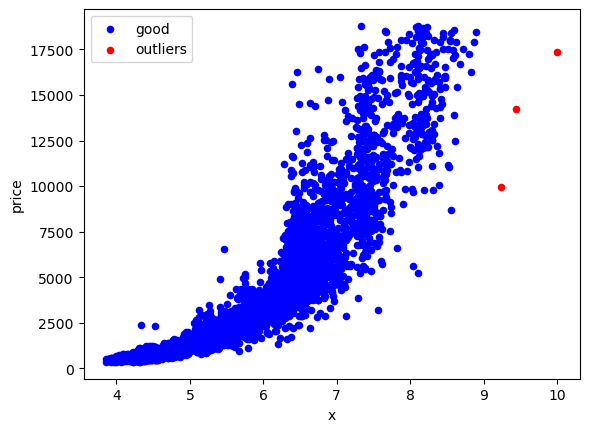

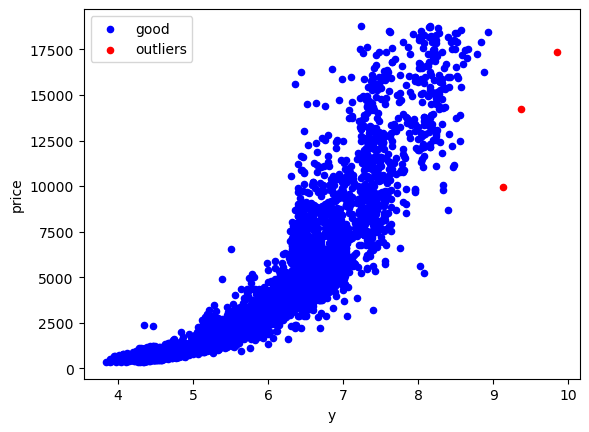

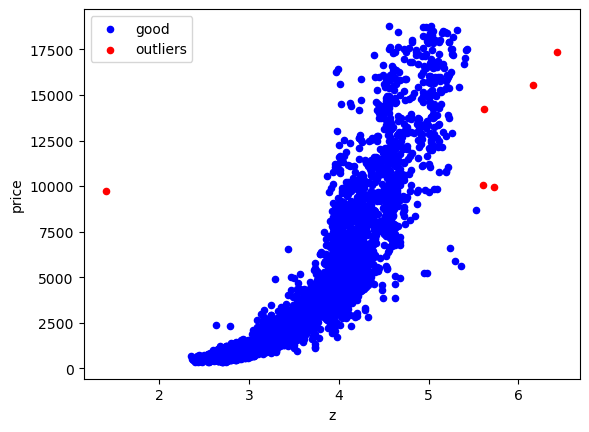

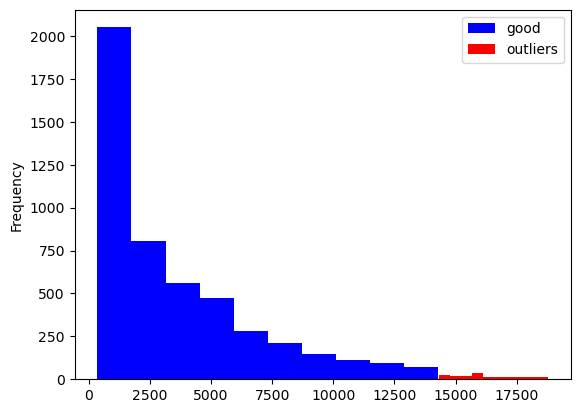

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# Go automate outlier detection

def z_score(col):
    sigma = col.std()
    mean = col.median()
    return np.abs((col - mean) / sigma)


def figure_outliers(data, threshold=3):
    for col_name in NUMERICAL_DATA:
        try:
            col = data[col_name]
        except:
            continue
        wout = data[z_score(col) < threshold]
        out = data[z_score(col) > threshold]
        fig, ax = plt.subplots()
        
        if col_name == TARGET:
            wout.plot(kind='hist', y=col_name, label='good', ax=ax, color='blue')
            out.plot(kind='hist', y=col_name, label='outliers', ax=ax, color='red')
            plt.show()
            continue
            
        wout.plot(kind='scatter', x=col_name, y='price', label='good', ax=ax, color='blue')
        out.plot(kind='scatter', x=col_name, y='price', label='outliers', ax=ax, color='red')
        plt.show()

figure_outliers(data)

I'll set threshold to 4 for ['table', 'depth', 'carat'] features

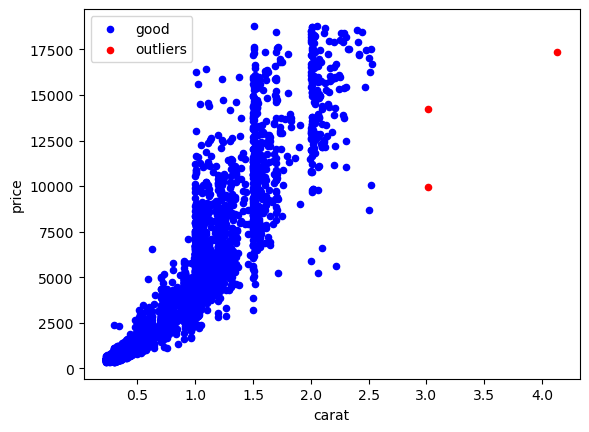

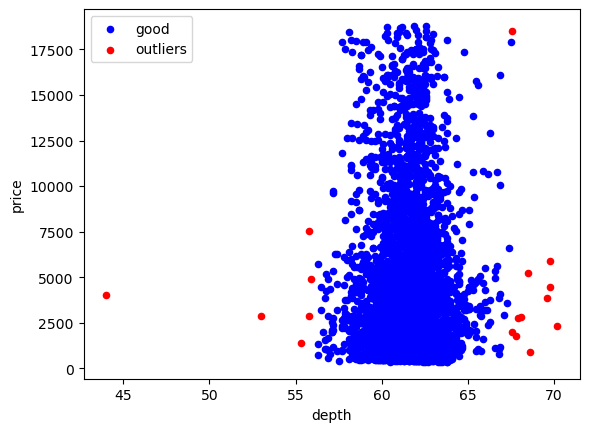

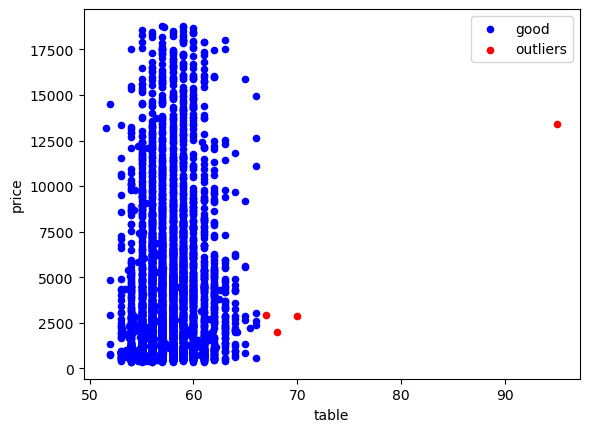

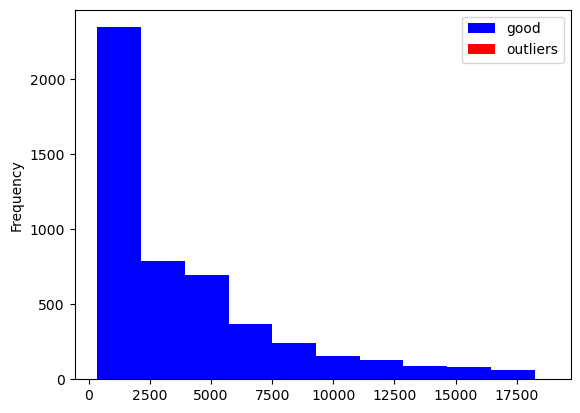

In [93]:
figure_outliers(data[['table', 'depth', 'carat', 'price']], 4)

Looks very good. Let's apply this

In [94]:
threshold_4_cols = ['table', 'depth', 'carat']
threshold_3_cols = ['x', 'y', 'z', 'price']

for col_name in threshold_4_cols:
    data = data[z_score(data[col_name]) < 4]

for col_name in threshold_3_cols:
    data = data[z_score(data[col_name]) < 3]

> I save the outliers and create a dataset without outliers

REVIEW: Categorical features

In [95]:
data['cut'].unique()

array(['Ideal', 'Premium', 'Very Good', 'Good', 'Fair'], dtype=object)

In [96]:
data['color'].unique()

array(['H', 'I', 'F', 'G', 'E', 'D', 'J'], dtype=object)

In [97]:
data['clarity'].unique()

array(['SI2', 'SI1', 'VS2', 'IF', 'VVS2', 'VS1', 'I1', 'VVS1'],
      dtype=object)

> Categorical features looks good

To Do

In [98]:
import numpy as np
import json
from typing import Literal

metadata_path = './preproc_metadata.json'

def oh_encoder(data, col_name):
    """One hot encoder"""
    encoded_df = pd.get_dummies(data[col_name], prefix=col_name, dtype=int)
    return data.drop(columns=[col_name]).join(encoded_df)

def label_encoder(data, col_name):
    """Label encoder"""
    label_map = {name:idx for idx, name in enumerate(data[col_name].unique())}
    data[col_name] = data[col_name].map(lambda x: label_map[x])
    return data

def num_scaler(data, col_name):
    """Standard scaler"""
    data[col_name] -= data[col_name].mean()
    data[col_name] /= data[col_name].std()
    return data

def target_scaler(data, col_name):
    col = data[col_name]
    col = np.log(col)
    mu = col.mean()
    std = col.std()
    data[col_name] = (col - mu) / std
    metadata = {'target_mu': mu, 'target_std': std}
    return data, metadata
    
def preprocess(
    data: pd.DataFrame,
    cat_features: list[str],
    num_features: list[str],
    target: str,
    encoder_type: Literal['label', 'ohe'] = 'ohe',
) -> pd.DataFrame:
    # Data follows simple distributions so I'll use standard scaler for numerical features
    # Also for categorical features I'll use vectors
    metadata = {}
    d = data.copy()
    cat_encoder = oh_encoder
    if encoder_type == 'label':
        cat_encoder = label_encoder

    for col_name in d.columns:
        if col_name in cat_features:
            d = cat_encoder(d, col_name)
        elif col_name in num_features:
            d = num_scaler(d, col_name)
        elif col_name == target:
            d, m = target_scaler(d, col_name)
            metadata.update(m)

    with open(metadata_path, 'w') as f:
        json.dump(metadata, f)

    return d

In [99]:
le_data = preprocess(data, CATEGORICAL_FEATURES, NUMERICAL_FEATURES, TARGET, encoder_type='label')
ohe_data = preprocess(data, CATEGORICAL_FEATURES, NUMERICAL_FEATURES, TARGET, encoder_type='ohe')

In [100]:
ohe_data

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.853403,0.209522,-1.103690,0.782836,0.937274,0.978032,0.984905,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,1.314564,0.650659,-0.643759,1.099267,1.273852,1.248895,1.359208,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,1.096120,-0.452183,0.276103,0.940290,1.196919,1.123138,1.094077,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,1.824269,-0.599228,-0.643759,1.421719,1.725827,1.664864,1.593147,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0.367970,-0.011046,-0.183828,0.728933,0.514148,0.552390,0.532622,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.894156,0.430091,-1.885573,-1.017953,-0.947561,-0.918010,-0.886610,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4996,-1.015514,-0.305137,0.736034,-0.905957,-1.139891,-1.179200,-1.182933,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4997,1.217478,0.283045,-0.643759,1.025079,1.129604,1.161832,1.187652,0,0,1,...,0,1,0,0,0,0,0,0,0,1
4998,-1.064057,0.871227,0.276103,-1.055993,-1.274522,-1.324305,-1.214125,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Correlations

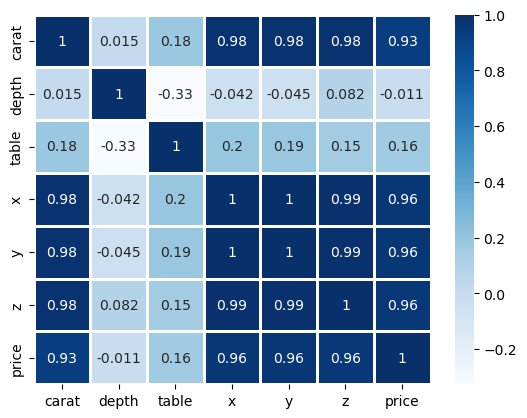

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.heatmap(le_data[NUMERICAL_DATA].corr(), cmap='Blues', linewidths=1, label='price', annot=True)
plt.show()

> We can see that the features "depth" and "table" have not correlation with the price nor features which do have correlations with price. Also "x", "y" and "z" are overcorrelated. Then I'll take one of them

In [20]:
NO_FEATURES = ['depth', 'table', 'y', 'z']
LABEL = 'price'

filtered_data = ohe_data[list(filter(lambda x: not x in NO_FEATURES, ohe_data.columns))]

### Machine Learning Models Benchmark

In [21]:
import sklearn.metrics as mets

class BenchmarkUtils:
    @staticmethod
    def split_dataset(data, features, label, train_pct=0.7, shuffle=False):
        d = data.copy()
        if shuffle:
            d = d.sample(frac=1)
        s = int(train_pct * d.shape[0])
        X_train, y_train = d[features][:s].to_numpy(), d[label][:s].to_numpy()
        X_test, y_test = d[features][s:].to_numpy(), d[label][s:].to_numpy()
        return  X_train, y_train.reshape(-1), X_test, y_test.reshape(-1)

    @staticmethod
    def compute_metrics(true, pred):
        metrics = [
            'max_error', 'root_mean_squared_error', 'explained_variance_score',
            'mean_absolute_error', 'r2_score'
        ]
        results = {}
        for m in metrics:
            if m == 'root_mean_squared_error':
                result = np.sqrt(mets.mean_squared_error(true, pred))
            else:
                result = getattr(mets, m)(true, pred)
            results.update({m:result})
        return results

In [22]:
import torch

class Benchmark(BenchmarkUtils):
    def __init__(self, models, data, features=None, label=LABEL, train_pct=0.5):
        if features is None:
            features = list(filter(lambda x: x != label, data.columns))

        self.models = [list(i) for i in models]
        self.X_train, self.y_train, self.X_test, self.y_test = (
            self.split_dataset(data, features, label, train_pct, shuffle=True)
        )

    def train_model_and_pred(self, _model):
        if isinstance(_model, torch.nn.Module):
            X_test = torch.tensor(self.X_test)
            y_pred = _model(X_test)
            return y_pred.numpy(), _model
        else:
            _model.fit(self.X_train, self.y_train)
            y_pred = _model.predict(self.X_test)
            return y_pred, _model

    def run(self, return_pandas=True):
        results = []
        for idx, (name, cls) in enumerate(self.models):
            y_pred, _model = self.train_model_and_pred(cls)
            self.models[idx][1] = _model
            result = self.compute_metrics(self.y_test, y_pred)
            result.update({'model': name})
            results.append(result)

        if return_pandas:
            return pd.DataFrame(results).set_index('model')

        return results

In [23]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, ElasticNet, Ridge
from sklearn.svm import SVR


models = (
    ('LinearRegression', LinearRegression()),
    ('RandomForestRegressor', RandomForestRegressor()),
    ('SGDRegressor', SGDRegressor()),
    ('Lasso', Lasso()),
    ('ElasticNet', ElasticNet()),
    ('Ridge', Ridge()),
    ('SVR-linear', SVR(kernel='linear')),
    ('SVR-rbf', SVR(kernel='rbf')),
    ('GradientBoostingRegressor', GradientBoostingRegressor()),
    ('AdaBoostRegressor', AdaBoostRegressor()),
    ('BaggingRegressor', BaggingRegressor())
)


# I'll use one hot encoder data in this case
bm = Benchmark(models, filtered_data)
results = bm.run()

In [24]:
results

,max_error,root_mean_squared_error,explained_variance_score,mean_absolute_error,r2_score
model,,,,,
LinearRegression,1.004021,0.161680,0.973853,0.126786,0.973734
RandomForestRegressor,0.954203,0.133311,0.982151,0.098770,0.982143
SGDRegressor,1.399569,0.194693,0.961975,0.150008,0.961913
Lasso,1.925424,0.997657,0.000000,0.869801,-0.000093
ElasticNet,1.575720,0.667395,0.552556,0.573844,0.552447
Ridge,0.985022,0.161556,0.973893,0.126682,0.973774
SVR-linear,0.971588,0.161175,0.973956,0.125758,0.973898
SVR-rbf,0.661344,0.122695,0.984892,0.096595,0.984874
GradientBoostingRegressor,0.821021,0.130662,0.982936,0.101046,0.982845


> Note that the best models are Ensembles. I also will add SVR-rbf to the random search because in my experience this model reach better loss values

Random search (Note that I won't doin an extense parameter search due to time consuming)

In [25]:
from sklearn.model_selection import RandomizedSearchCV


rf_random_grid = dict(
    criterion = ['squared_error'],
    n_estimators = np.arange(100, 1000, 100),
    max_depth = [None, 3, 5, 10],
)

rf_model = RandomForestRegressor()
rf_random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=rf_random_grid,
    n_iter=5,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)

In [26]:
svr_random_grid = dict(
    C = np.linspace(0.5, 5, 10),
    epsilon = np.linspace(0, 1, 11),
    degree = [2, 3, 4],
)

svr_model = SVR(kernel='rbf', tol=1e-2)
svr_random_search = RandomizedSearchCV(
    svr_model,
    param_distributions=svr_random_grid,
    n_iter=20,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)

In [27]:
gb_random_grid = dict(
    loss = ['squared_error'],
    learning_rate = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    n_estimators = np.arange(100, 1000, 100),
)

gb_model = GradientBoostingRegressor()
gb_random_search = RandomizedSearchCV(
    gb_model,
    param_distributions=gb_random_grid,
    n_iter=5,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)

In [28]:
searchs = (
    ('random_forest_search', rf_random_search),
    ('gradient_bost_search', gb_random_search),
    ('svr-rbf_search', svr_random_search),
)

search_bm = Benchmark(searchs, filtered_data)
search_results = search_bm.run()

In [29]:
search_results

,max_error,root_mean_squared_error,explained_variance_score,mean_absolute_error,r2_score
model,,,,,
random_forest_search,0.879110,0.140398,0.980069,0.106459,0.980068
gradient_bost_search,0.899924,0.133197,0.982061,0.103899,0.982060
svr-rbf_search,0.691560,0.121077,0.985177,0.091092,0.985176


In [44]:
best_model = dict(search_bm.models)['svr-rbf_search']

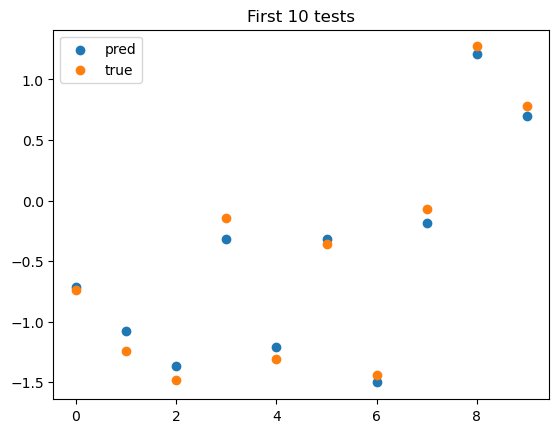

In [45]:
X_test = search_bm.X_test

y_test = search_bm.y_test
y_pred = best_model.predict(X_test)

plt.scatter(range(10), y_pred[:10], label='pred')
plt.scatter(range(10), y_test[:10], label='true')
plt.legend(loc="upper left")
plt.title('First 10 tests')
plt.show()

Good! now, I wanna apply a bit of deep learning

### Deep Learning

In [32]:
import torch

class RegressionModel(torch.nn.Module):
    def __init__(self, cat_features_amount, embedding_dim, num_features_amount):
        super(RegressionModel, self).__init__()
        self.embedding = torch.nn.Embedding(
            num_embeddings=cat_features_amount,
            embedding_dim=embedding_dim
        )

        self.input_size = (embedding_dim * cat_features_amount) + num_features_amount
        self.layer1 = torch.nn.Sequential(
            torch.nn.Linear(self.input_size, 512),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(512),
            torch.nn.Dropout(0.5)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(256),
            torch.nn.Dropout(0.3)
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(128),
            torch.nn.Dropout(0.3)
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(64),
            torch.nn.Dropout(0.3)
        )
        self.output = torch.nn.Linear(64, 1)

    def forward(self, x_cat, x_num):
        x_cat = self.embedding(x_cat)
        x_cat = x_cat.view(x_cat.size(0), -1)
        x = torch.cat([x_cat, x_num], dim=1)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.output(x)
        return x


In [33]:
from torch.utils.data import DataLoader, Dataset, random_split

class OHEDataset(Dataset):
    def __init__(self, data, cat_features, num_features, label):
        self.data = data
        self.cat_features = cat_features
        self.num_features = num_features
        self.label = label

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        x_num = torch.from_numpy(
            row[self.num_features].to_numpy().astype(np.float32)
        ).view(-1)

        x_cat = torch.from_numpy(
            row[self.cat_features].to_numpy().astype(np.int32)
        ).view(-1)

        target = torch.from_numpy(row[[self.label]].to_numpy().astype(np.float32))
        return x_cat, x_num, target

In [34]:
CATEGORICAL_FEATURES = [
    'cut_Fair', 'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good',
    'color_D', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_I1', 'clarity_IF',
    'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2'
]
NUMERICAL_FEATURES = [
    'carat', 'x'
]
LABEL = 'price'


dataset = OHEDataset(filtered_data, CATEGORICAL_FEATURES, NUMERICAL_FEATURES, LABEL)

train_dataset, test_dataset, val_dataset = random_split(dataset, [0.6, 0.3, 0.1])

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=True)

In [35]:
embedding_dim = 3

model = RegressionModel(len(CATEGORICAL_FEATURES), embedding_dim, len(NUMERICAL_FEATURES))
loss_fn = torch.nn.MSELoss()
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

/Users/nico/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Training loop

In [36]:
num_epochs = 200
best_loss = float('inf')

losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_cat, x_num, y in train_loader:
        optimizer.zero_grad()
        pred = model(x_cat, x_num)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_cat.size(0)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_cat, x_num, y in val_loader:
            pred = model(x_cat, x_num)
            loss = loss_fn(pred, y)
            val_loss += loss.item() * x_cat.size(0)

    train_loss = train_loss / len(train_dataset)
    val_loss = val_loss / len(val_dataset)
    
    if val_loss < best_loss:
        torch.save(model, './best_model.pt')

    losses.append({'val': val_loss, 'train': train_loss})

    print('\r', f'Epoch {epoch+1}, train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, lr: {round(optimizer.param_groups[0]["lr"], 6)}', end='')


 Epoch 200, train_loss: 0.0311, val_loss: 0.0150, lr: 0.001

#### Testing loop

<Axes: >

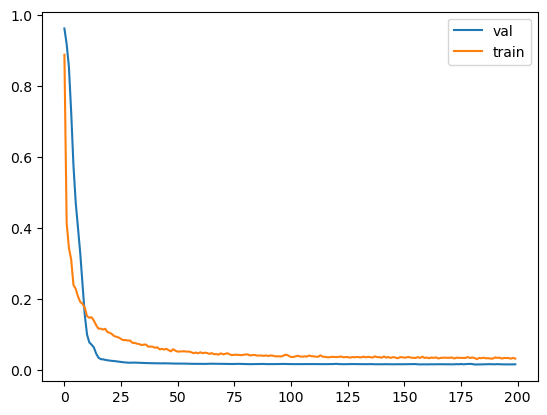

In [37]:
pd.DataFrame(losses).plot()

In [120]:
best_model = torch.load('./best_model.pt')

/Users/nico/micromamba/envs/fwai/lib/python3.10/site-packages/torch/serialization.py:995: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [121]:
best_model.eval()
test_loss = 0.0
with torch.no_grad():
    for x_cat, x_num, y in test_loader:
        pred = best_model(x_cat, x_num)
        loss = loss_fn(pred, y)
        test_loss += loss.item() * x_cat.size(0)

test_loss = test_loss / len(test_dataset)
print(f"Test loss: {test_loss}")

Test loss: 0.014073009007822103


Ok, looks really good. Go compare with our benchmark metrics

In [106]:
best_model.eval()

preds = []
trues = []
with torch.no_grad():
    for x_cat, x_num, y in test_loader:
        pred = best_model(x_cat, x_num)
        preds.append(pred)
        trues.append(y)


In [107]:
preds = torch.cat(preds).numpy()
trues = torch.cat(trues).numpy()

In [108]:
results = BenchmarkUtils.compute_metrics(preds, trues)
pd.DataFrame(results, index={'DL': 'model'})

,max_error,root_mean_squared_error,explained_variance_score,mean_absolute_error,r2_score
DL,0.493685,0.11863,0.985683,0.093362,0.985585


Excellent! I'll continue with DeepLearning model for the next step, because I love pytorch. Note that GradientBostingRegressor is better, however when you scale DeepLearning models they are unbeatable

In [119]:
torch.jit.script(model).save('best_model.pt')